In [40]:
#Import packages
import pandas as pd
import numpy as np
import glob
import re
import string
import codecs
import spacy
import matplotlib.pyplot as plt

# Parliamentary Questions Analysis

In [2]:
#Create single parliament_qs dataframe with all question data
li = []

for file in glob.glob('./Parliament_Qs/rajyasabha_questions_and_answers_*.csv'):
    data = pd.read_csv(file)
    li.append(data)
    
parliament_qs = pd.concat(li, axis = 0, ignore_index = True)

In [16]:
#Code borrowed and adapted from George Chen, Carnegie Mellon University#
#Define function to remove punctuation and whitespace, and lowercase all text
def makeWordList(str_object):
    
    corpus_text = str(str_object)
    
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [25]:
#Process the questions
processed_questions = []

for str_object in list(parliament_qs["question_description"]):
    processed_questions.append(makeWordList(str_object))

In [4]:
#Process responses
processed_answers = []

for str_object in list(parliament_qs["answer"]):
    processed_answers.append(makeWordList(str_object))

In [51]:
#Use TfidfVectorizer to transform parliamentary questions
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=200, stop_words="english", max_df=0.8)
questions_fit = vectorizer.fit(processed_questions)
X_questions = vectorizer.fit_transform(processed_questions).toarray()

In [ ]:
#!Time-consuming!#
#Create topics using LDA
num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0)
lda.fit(X_questions)

In [ ]:
#Display top 10 words from each topic
words = list(questions_fit.vocabulary_)
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])
num_top_words = 10

print('Displaying the top 10 words per topic and their probabilities within the topic...')
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(words[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()

In [52]:
#Use TfidfVectorizer to transform parliamentary answers
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=200, stop_words="english", max_df=0.8)
answers_fit = vectorizer.fit(processed_answers)
X_answers = vectorizer.fit_transform(processed_answers).toarray()

In [ ]:
#!Time-consuming!#
#Create topics using LDA
num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda_answers = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0)
lda_answers.fit(X_answers)

In [ ]:
#Display top 10 words from each topic
words = list(answers_fit.vocabulary_)
topic_word_distributions = np.array([row / row.sum() for row in lda_answers.components_])
num_top_words = 10

print('Displaying the top 10 words per topic and their probabilities within the topic...')
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(words[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()

# Headline Analysis

In [27]:
li = []

for file in glob.glob('./india_headlines_data/*.csv'):
    data = pd.read_csv(file)
    li.append(data)
    
headlines = pd.concat(li, axis = 0, ignore_index = True)

In [29]:
headlines

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,bollywood,Raju Chacha
2,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
3,20010102,unknown,Fissures in Hurriyat over Pak visit
4,20010102,unknown,America's unwanted heading for India?
...,...,...,...
2969917,20181231,world.us,For wedding guests; now a hair and glam touch-...
2969918,20181231,world.us,Guatemala village mourns 2nd child to die in U...
2969919,20181231,world.us,Veterans' support for Donald Trump strong: AP ...
2969920,20181231,world.us,aides give conflicting signals on donald trump...


In [32]:
#Process headlines, delete headlines object, sample 10% of processed headlines
import random
processed_headlines = []
random.seed(42)
headlines = random.sample(list(headlines["headline_text"]), round(len(headlines)/10))
                          
for str_object in headlines:
    processed_headlines.append(makeWordList(str_object))

In [33]:
#Use TfidfVectorizer to transform headlines
##Memory intensive##
from sklearn.feature_extraction.text import TfidfVectorizer
headline_vectorizer = TfidfVectorizer(min_df=200, stop_words="english", max_df=0.8)
headlines_fit = headline_vectorizer.fit(processed_headlines)
X_headlines = headline_vectorizer.fit_transform(processed_headlines).toarray()

In [34]:
num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda_headlines = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0)
lda_headlines.fit(X_headlines)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [53]:
words = list(headlines_fit.vocabulary_)
topic_word_distributions = np.array([row / row.sum() for row in lda_headlines.components_])
num_top_words = 15

print('Displaying the top 15 words per topic and their probabilities within the topic...')
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(words[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()

Displaying the top 15 words per topic and their probabilities within the topic...

[Topic 0]
labour : 0.03860330906379886
mission : 0.03374031671009788
course : 0.032462592063320285
cheating : 0.02674135554586314
filed : 0.02570318762380012
education : 0.01826181535798846
cop : 0.017738767759230903
scare : 0.014018263958041628
chhattisgarh : 0.013574345666579408
bar : 0.013280687501206163
demolition : 0.013279851005599978
special : 0.012612841793144087
rescued : 0.012484319189964543
nitish : 0.012426966066449644
tea : 0.011100287764688058

[Topic 1]
bollywood : 0.05652672305509811
mc : 0.020877611782112865
chinese : 0.01951978015539641
cell : 0.01862620140313285
fuel : 0.018525507570669772
common : 0.0182746225720331
fears : 0.018235411934387834
caught : 0.018131542869644003
kochi : 0.017012086919733094
trouble : 0.016547194568394756
rajnath : 0.016134089512989107
pcb : 0.015644805058001872
victims : 0.014713646625735328
like : 0.01412784409134809
maharashtra : 0.013461724967668289

[T

## Topics just above here. Thanks Shreya!

## Relgious Headline Analysis

In [16]:
li = []

for file in glob.glob('./india_headlines_data_pre/religious*.csv'):
    data = pd.read_csv(file)
    li.append(data)
    
religious_headlines_pre = pd.concat(li, axis = 0, ignore_index = True)

li = []

for file in glob.glob('./india_headlines_data_post/religious*.csv'):
    data = pd.read_csv(file)
    li.append(data)
    
religious_headlines_post = pd.concat(li, axis = 0, ignore_index = True)

In [17]:
#Process religious headlines
processed_religious_headlines_pre = []

for str_object in list(religious_headlines_pre["headline_text"]):
    processed_religious_headlines_pre.append(makeWordList(str_object))
    
processed_religious_headlines_post = []

for str_object in list(religious_headlines_post["headline_text"]):
    processed_religious_headlines_post.append(makeWordList(str_object))

In [36]:
#Use TfidfVectorizer to transform religious headlines
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_pre = TfidfVectorizer(min_df=100, stop_words="english", max_df=0.8)
rel_headlines_pre_fit = vectorizer_pre.fit(processed_religious_headlines_pre)
X_rel_headlines_pre = vectorizer.fit_transform(processed_religious_headlines_pre).toarray()

vectorizer_post = TfidfVectorizer(min_df=100, stop_words="english", max_df=0.8)
rel_headlines_post_fit = vectorizer_post.fit(processed_religious_headlines_post)
X_rel_headlines_post = vectorizer_post.fit_transform(processed_religious_headlines_post).toarray()

In [37]:
num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda_rel_headlines_pre = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0)
lda_rel_headlines_pre.fit(X_rel_headlines_pre)

lda_rel_headlines_post = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0)
lda_rel_headlines_post.fit(X_rel_headlines_post)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [38]:
words = list(rel_headlines_pre_fit.vocabulary_)
topic_word_distributions = np.array([row / row.sum() for row in lda_rel_headlines_pre.components_])
num_top_words = 10

print('Displaying the top 10 words per topic and their probabilities within the topic for pre-election relgious headlines')
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(words[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()

words = list(rel_headlines_post_fit.vocabulary_)
topic_word_distributions = np.array([row / row.sum() for row in lda_rel_headlines_post.components_])
num_top_words = 10

print('Displaying the top 10 words per topic and their probabilities within the topic for post-election relgious headlines')
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(words[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()

Displaying the top 10 words per topic and their probabilities within the topic for pre-election relgious headlines

[Topic 0]
gets : 0.3325878908343633
vhp : 0.1410741139730405
land : 0.09764653418812733
rain : 0.07304272493430007
women : 0.06716153659901956
polls : 0.06155488657925728
high : 0.06152229777309942
churches : 0.04688881030527306
hindus : 0.04190856687229721
offer : 0.04053579900361241

[Topic 1]
monk : 0.09765610426785298
babri : 0.08782965075859098
gujarat : 0.08167533787612587
centre : 0.07756836684415125
rss : 0.0736208801311144
day : 0.07045636329665927
pakistan : 0.06295241149101867
body : 0.05652299472458706
modi : 0.056406034055761056
today : 0.053136787481863235

[Topic 2]
body : 0.24650077884660038
leader : 0.19598466160003897
demand : 0.07515014473444322
prayer : 0.07069654233678867
court : 0.06340698526049049
set : 0.0614349715701121
christian : 0.05403263248965024
new : 0.044979946185935954
party : 0.038278258138742534
state : 0.03787685008210023

[Topic 3]
as

# Applying Headlines Topics to Parliament Data

In [73]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'tagger'])
nlp.max_length = 10000000
processed_answers_for_headline_topics = []
out_of_topics_mask = []
in_topics_mask = []
for answer in np.array(parliament_qs["answer"]):
    parsed = nlp(str(answer))
    processed_answer_list = []
    out_of_topics_count = 0
    in_topics_count = 0
    for token in parsed:
        if re.match('[a-zA-Z]+$', token.orth_):
            token_lemma = token.lemma_.lower()
            if token_lemma in headlines_fit.vocabulary_:
                processed_answer_list.append(token_lemma)
                in_topics_count += 1
            else:
                out_of_topics_count += 1
    processed_answer_str = " ".join(processed_answer_list)
    processed_answers_for_headline_topics.append(processed_answer_str)
    out_of_topics_mask.append(out_of_topics_count)
    in_topics_mask.append(in_topics_count)

In [74]:
X_answers_for_headline_topics = headline_vectorizer.transform(processed_answers_for_headline_topics[:10000]).toarray()

In [75]:
answers_distribution_of_headline_topics = lda_headlines.transform(X_answers_for_headline_topics)

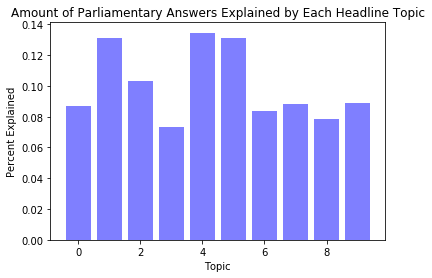

In [76]:
sum_explained_per_topic = []
for i in range(num_topics):
    sum_explained_per_topic.append(sum(answers_distribution_of_headline_topics[:,i]))
per_explained_per_topic = []
for i in range(num_topics):
    x = sum_explained_per_topic[i]/sum(sum_explained_per_topic)
    per_explained_per_topic.append(x)

plt.bar(range(10), per_explained_per_topic, facecolor='blue', alpha=0.5)
plt.xlabel('Topic')
plt.ylabel('Percent Explained')
plt.title('Amount of Parliamentary Answers Explained by Each Headline Topic')
plt.show()

In [77]:
sum(in_topics_mask)/(sum(in_topics_mask)+sum(out_of_topics_mask))

0.2588384462991717